In [1]:
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Linear regression models
## Dataset creation
### Create synthetic data

In [2]:
gt_samples = 1000
gt_bias = 13
gt_noise = 10
gt_random_state = 42

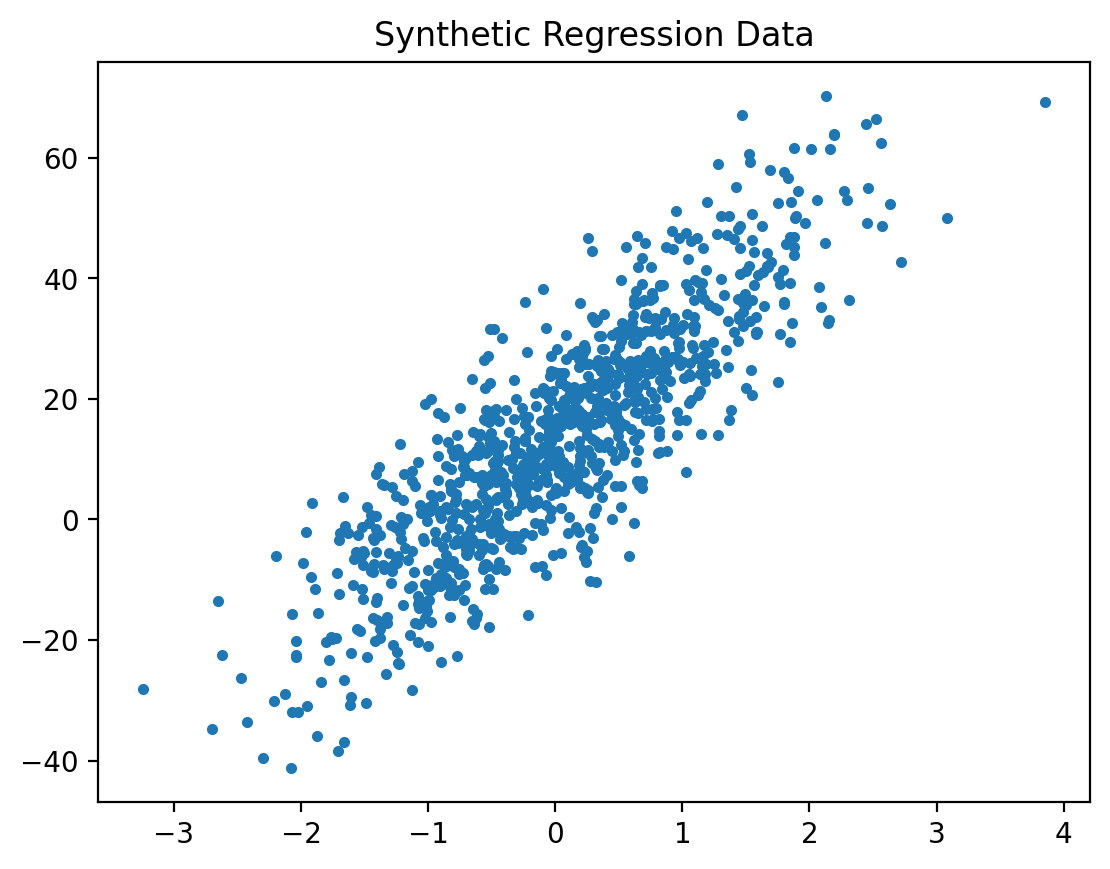

ground truth coef = 16.7483, bias = 13.0000


In [3]:
X, y, gt_coef = make_regression(
    n_samples=gt_samples, 
    n_features=1, 
    bias=gt_bias, 
    noise=gt_noise, 
    coef=True, 
    random_state=gt_random_state
)
x = X.reshape(-1)
plt.plot(x, y, '.')
plt.title('Synthetic Regression Data')
plt.show()
print(f'ground truth coef = {gt_coef:.04f}, bias = {gt_bias:.04f}')

### Add datetime index

In [4]:
import pandas as pd
import numpy as np
import datetime

df = pd.DataFrame(np.stack((x, y), axis=1), columns=('x', 'y'))
x_to_dt = lambda x: datetime.timedelta(days=x * 30)
start = datetime.datetime.now() - x_to_dt(min(df['x']))
dt_index = [start + x_to_dt(x) for x in df['x']]
df.index = pd.DatetimeIndex(dt_index, name='date')
df = df.sort_index()
df = df.drop(columns='x')
df.head()

,y
date,
2023-03-29 08:32:38.607163,-28.145488
2023-04-14 16:29:53.374117,-34.823622
2023-04-16 01:33:29.809267,-13.469901
2023-04-17 00:02:24.242821,-22.405377
2023-04-21 10:40:21.008292,-26.338877
2023-04-22 21:03:48.338000,-33.534158
2023-04-26 12:52:23.893627,-39.558250
2023-04-29 06:14:20.831674,-30.072788
2023-04-29 15:06:58.513063,-6.135003


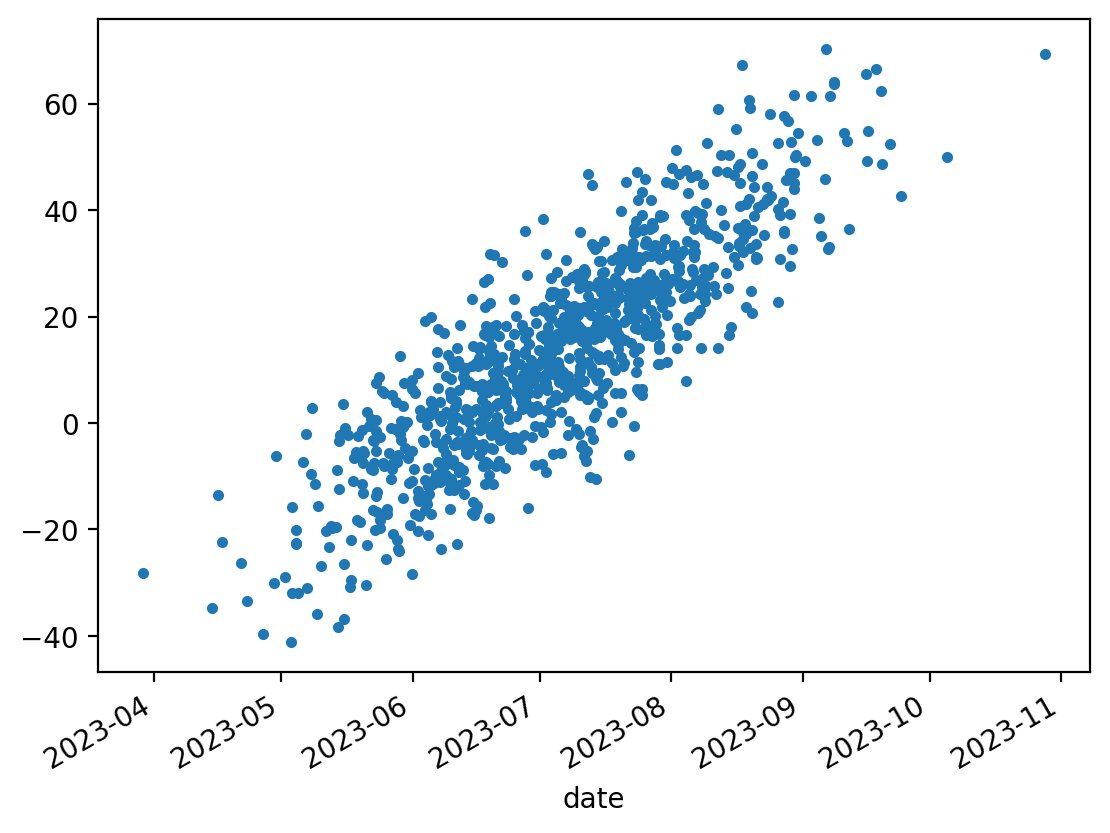

In [5]:
df['y'].plot(style='.')
plt.show()

### Save dataset

In [6]:
dataset_path = './data/data.csv'
df.to_csv(dataset_path)

## Model development

Simulate receiving external dataset in csv format.

In [7]:
df = pd.read_csv(dataset_path, index_col='date', parse_dates=True)
df.head()

,y
date,
2023-03-29 08:32:38.607163,-28.145488
2023-04-14 16:29:53.374117,-34.823622
2023-04-16 01:33:29.809267,-13.469901
2023-04-17 00:02:24.242821,-22.405377
2023-04-21 10:40:21.008292,-26.338877


### Convert datetime index to numbers

We should take note of start_date and the fact that the unit of the x axis will be seconds. We will need this information when converting back x values to datetime at prediction time.

In [8]:
start_date = df.index.min()
df['x'] = (df.index - start_date)
df['x'] = df['x'].dt.total_seconds()
df.head()

,y,x
date,,
2023-03-29 08:32:38.607163,-28.145488,0.000000e+00
2023-04-14 16:29:53.374117,-34.823622,1.411035e+06
2023-04-16 01:33:29.809267,-13.469901,1.530051e+06
2023-04-17 00:02:24.242821,-22.405377,1.610986e+06
2023-04-21 10:40:21.008292,-26.338877,1.994862e+06


In [9]:
x = df['x'].to_numpy()
y = df['y'].to_numpy()

### sklearn.linear_model.LinearRegression

sklearn.linear_model coef=0.0000, bias=-40.8685


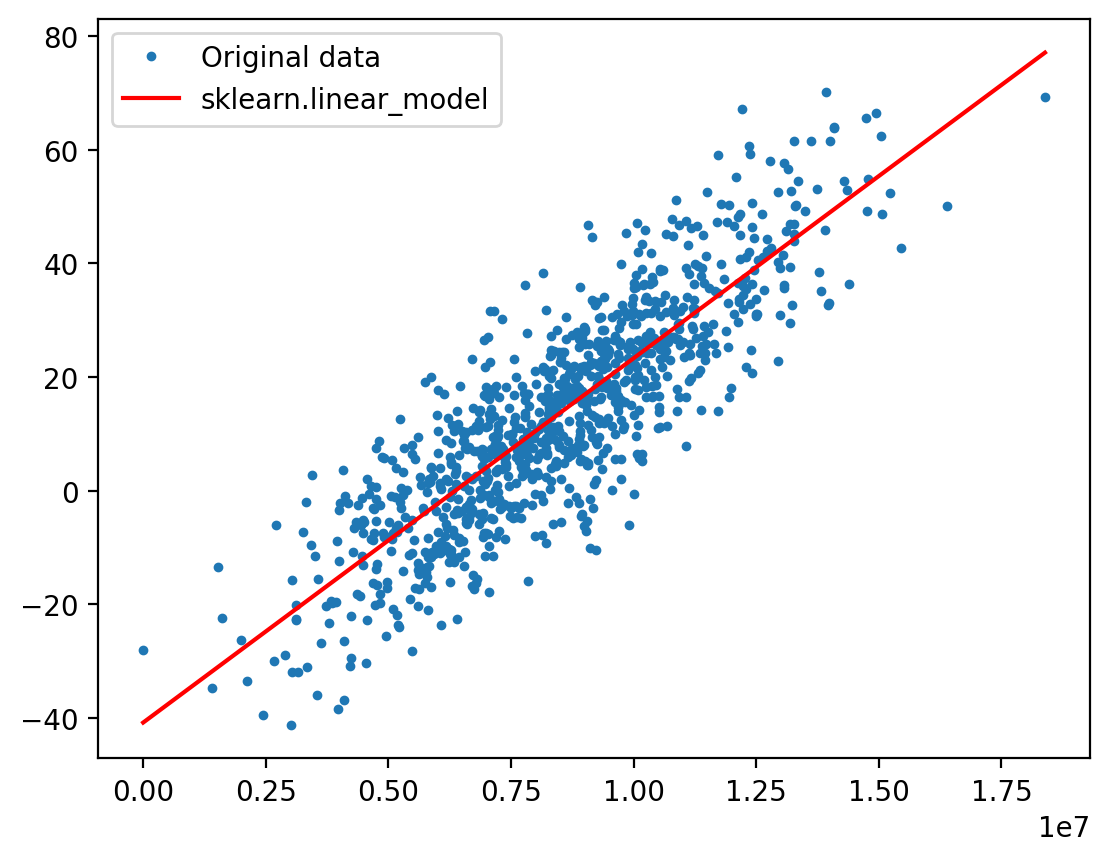

In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

A = x.reshape((-1, 1))
model.fit(A, y)
bias = model.intercept_
coef = model.coef_[0]
print(f'sklearn.linear_model coef={coef:.04f}, bias={bias:.04f}')

plt.plot(x, y, '.', label='Original data', markersize=5)
plt.plot(x, coef*x + bias, 'r', label='sklearn.linear_model')
plt.legend()
plt.show()

#### Timing

In [11]:
%%timeit
model.fit(X, y)

681 µs ± 52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### np.linalg.lstsq

np.linalg.lstsq coef=0.0000, bias=-40.8685


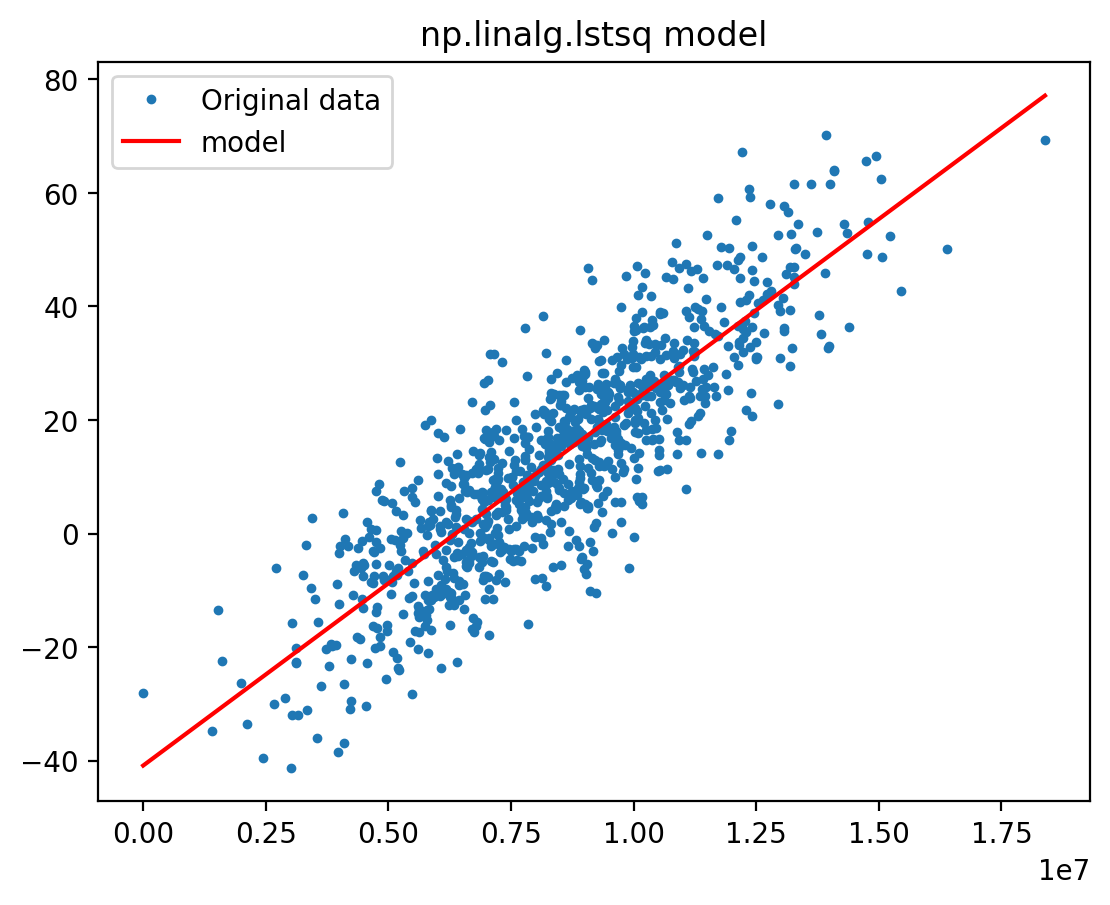

In [12]:
import numpy as np

A = np.vstack([x, np.ones(len(x))]).T
coef, bias = np.linalg.lstsq(A, y, rcond=None)[0]
print(f'np.linalg.lstsq coef={coef:.04f}, bias={bias:.04f}')

plt.plot(x, y, '.', label='Original data', markersize=5)
plt.plot(x, coef*x + bias, 'r', label='model')
plt.title('np.linalg.lstsq model')
plt.legend()
plt.show()

#### Timing

In [13]:
%%timeit
np.linalg.lstsq(A, y, rcond=None)[0]

40.3 µs ± 843 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Prediction

In predictive maintenance we want to know when the regression model will cross a certain threshold.

In [14]:
target_threshold = 100

crossing = (target_threshold - bias) / coef
crossing_dt = start_date + pd.Timedelta(seconds=crossing)
print(f'Predicted threshold crossing: {crossing_dt}')

Predicted threshold crossing: 2023-12-08 10:10:51.711607252
